In [249]:
import os
from datetime import datetime, timedelta, timezone

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import requests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import HTML, display
from scipy.optimize import minimize
from scipy.stats import poisson

In [250]:
# Avoid line breaks by Jupyter (following https://stackoverflow.com/a/70433850/7395592)
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))
# Avoid premature line breaks by Numpy and show all array entries
np.set_printoptions(linewidth=np.inf, threshold=np.inf)
np.set_printoptions(suppress=True)

In [251]:
sim_date = datetime.fromisoformat("2024-06-14").replace(tzinfo=pytz.UTC)
sim_year_max = 2024
sim_year_min = 2012

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/125.0.0.0 Safari/537.36"
}

uefa = {
    "competition_id": 3,
    "url_competition": "https://comp.uefa.com/v2/competition-structure",
    "url_matches": "https://match.uefa.com/v5/matches",
    "url_teams": "https://comp.uefa.com/v2/teams",
    "season_years": range(sim_year_max, sim_year_min - 1, -4),
}

In [252]:
def get_nested_value(d, keys, default=None):
    for key in keys:
        if isinstance(d, dict):
            d = d.get(key, default)
        else:
            return default
    return d

In [253]:
def get_all_match_data(competition_id, season_years, limit=100):

    data = []
    for season_year in season_years:

        params = {
            "competitionId": competition_id,
            "seasonYear": season_year,
            "limit": limit,
        }

        data_season = []
        for offset in range(0, limit * 5, limit):

            params_iter = {"offset": offset}
            _params = params | params_iter
            response = requests.get(
                uefa["url_matches"], params=_params, headers=headers
            )

            data_iter = response.json()
            if not data_iter:
                break

            data_season += data_iter

        data += data_season

    data_reduced = []
    for record in data:

        datetime_str = get_nested_value(record, ["kickOffTime", "dateTime"])
        datetime_offset_str = get_nested_value(
            record, ["kickOffTime", "utcOffsetInHours"]
        )
        if datetime_str is None:
            is_completed = False
            parsed_date = None
        else:
            parsed_date = datetime.fromisoformat(
                datetime_str.replace("Z", "+00:00")
            ) + timedelta(hours=datetime_offset_str)
            current_date = datetime.now(timezone.utc)
            is_completed = parsed_date < current_date

        home_score_total = get_nested_value(record, ["score", "total", "home"])
        away_score_total = get_nested_value(record, ["score", "total", "away"])

        home_team_code = get_nested_value(record, ["homeTeam", "teamCode"])
        away_team_code = get_nested_value(record, ["awayTeam", "teamCode"])

        score_summary = (
            None
            if home_score_total is None
            else " ".join(
                [
                    home_team_code,
                    str(home_score_total),
                    "-",
                    str(away_score_total),
                    away_team_code,
                ]
            )
        )

        result = (
            None
            if home_score_total is None
            else (
                "H"
                if home_score_total > away_score_total
                else "A" if home_score_total < away_score_total else "D"
            )
        )

        status = get_nested_value(record, ["round", "status"])
        if status == "UPCOMING":
            continue

        record_reduced = {
            "id": record["id"],
            "season_year": record["seasonYear"],
            "date": parsed_date,
            # Context
            # "round": get_nested_value(record, ["round", "id"]),
            "phase": get_nested_value(record, ["round", "phase"]),
            "mode": get_nested_value(record, ["round", "mode"]),
            "status": status,
            "is_completed": is_completed,
            # Home Team
            "home_team": get_nested_value(record, ["homeTeam", "id"]),
            "home_team_name": get_nested_value(
                record, ["homeTeam", "internationalName"]
            ),
            "home_team_code": home_team_code,
            "home_score": get_nested_value(record, ["score", "regular", "home"]),
            "home_score_total": home_score_total,
            # Away Team
            "away_team": get_nested_value(record, ["awayTeam", "id"]),
            "away_team_name": get_nested_value(
                record, ["awayTeam", "internationalName"]
            ),
            "away_team_code": away_team_code,
            "away_score": get_nested_value(record, ["score", "regular", "away"]),
            "away_score_total": away_score_total,
            # Score/Result
            "score": score_summary,
            "result": result,
            # "temperature": get_nested_value(record, ["condition", "temperature"]),
            # "humidity": get_nested_value(record, ["condition", "humidity"]),
            # "windSpeed": get_nested_value(record, ["condition", "windSpeed"]),
            # "pitchCondition": get_nested_value(record, ["condition", "pitchCondition"]),
            # "weatherCondition": get_nested_value(record, ["condition", "weatherCondition"]),
        }
        data_reduced.append(record_reduced)
        # print({k: type(v) for k, v in record_reduced.items()})

    df = pd.DataFrame(data_reduced)

    return df

In [254]:
matches = get_all_match_data(uefa["competition_id"], uefa["season_years"])

In [255]:
matches_ = matches

matches_ = matches_.loc[matches_["is_completed"]]
# matches_ = matches_.loc[matches_["date"] < sim_date]
matches_ = matches_.loc[matches_["home_score_total"] >= 0]

matches_["date"] = pd.to_datetime(matches_["date"])
matches_["time_diff"] = (max(matches_["date"]) - matches_["date"]).dt.days
matches_ = matches_.drop(
    ["is_completed", "home_score", "away_score", "home_team", "away_team"], axis=1
)
matches_ = matches_.rename(
    columns={
        "home_score_total": "HomeGoals",
        "away_score_total": "AwayGoals",
        "home_team_name": "home_team",
        "away_team_name": "away_team",
    }
)
matches_ = matches_[
    ["id", "home_team", "away_team", "HomeGoals", "AwayGoals", "time_diff","date"]
]
matches_.mean(numeric_only=True)

HomeGoals       1.561479
AwayGoals       1.231298
time_diff    2551.141015
dtype: float64

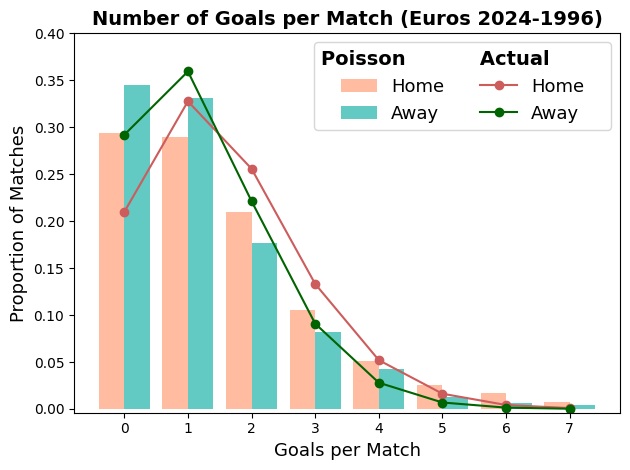

In [256]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack(
    [
        [poisson.pmf(i, matches_.mean(numeric_only=True).iloc[j]) for i in range(8)]
        for j in range(2)
    ]
)

# plot histogram of actual goals
plt.hist(
    matches_[["HomeGoals", "AwayGoals"]].values,
    range(9),
    alpha=0.7,
    label=["Home", "Away"],
    density=True,
    color=["#FFA07A", "#20B2AA"],
)

# add lines for the Poisson distributions
(pois1,) = plt.plot(
    [i - 0.5 for i in range(1, 9)],
    poisson_pred[:, 0],
    linestyle="-",
    marker="o",
    label="Home",
    color="#CD5C5C",
)
(pois2,) = plt.plot(
    [i - 0.5 for i in range(1, 9)],
    poisson_pred[:, 1],
    linestyle="-",
    marker="o",
    label="Away",
    color="#006400",
)

leg = plt.legend(loc="upper right", fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop={"size": "14", "weight": "bold"})

plt.xticks([i - 0.5 for i in range(1, 9)], [i for i in range(8)])
plt.xlabel("Goals per Match", size=13)
plt.ylabel("Proportion of Matches", size=13)
plt.title("Number of Goals per Match (Euros 2024-1996)", size=14, fontweight="bold")
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

In [257]:
# importing the tools required for the Poisson regression model


goal_model_data = pd.concat(
    [
        matches_[["home_team", "away_team", "HomeGoals"]]
        .assign(home=1)
        .rename(
            columns={"home_team": "team", "away_team": "opponent", "HomeGoals": "goals"}
        ),
        matches_[["away_team", "home_team", "AwayGoals"]]
        .assign(home=0)
        .rename(
            columns={"away_team": "team", "home_team": "opponent", "AwayGoals": "goals"}
        ),
    ]
)

poisson_model = smf.glm(
    formula="goals ~ home + team + opponent",
    data=goal_model_data,
    family=sm.families.Poisson(),
).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                 2326
Model:                            GLM   Df Residuals:                     2214
Model Family:                 Poisson   Df Model:                          111
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3063.1
Date:                Wed, 19 Jun 2024   Deviance:                       2179.4
Time:                        16:10:06   Pearson chi2:                 1.97e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4780
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -0.1783      0.213     -0.837      0.402      -0.596       0.239
team[T.Andorra]                       -1.4438      0.336     -4.300      0.000      -2.102      -0.786
team[T.Armenia]                        0.1654      0.205      0.806      0.420      -0.237       0.567
team[T.Austria]                        0.3378      0.187      1.810      0.070      -0.028       0.704
team[T.Azerbaijan]                    -0.2481      0.240     -1.035      0.301      -0.718       0.222
team[T.Belarus]                       -0.4997      0.238     -2.103      0.035      -0.965      -0.034
team[T.Belgium]                        0.6236      0.174      3.577      0.000       0.282       0.965
team[T.Bosnia and Herzegovina]         0.1568      0.191      0.821      0.411      -0.217       0.531
team[T.Bulgaria]                      -0.4646      0.249     -1.868      0.062      -0.952       0.023
team[T.Croatia]                        0.4047      0.184      2.200      0.028       0.044       0.765
team[T.Cyprus]                        -0.1015      0.216     -0.469      0.639      -0.526       0.323
team[T.Czechia]                        0.1984      0.189      1.047      0.295      -0.173       0.570
team[T.Denmark]                        0.3218      0.184      1.747      0.081      -0.039       0.683
team[T.England]                        0.7087      0.174      4.067      0.000       0.367       1.050
team[T.Estonia]                       -0.6612      0.250     -2.648      0.008      -1.151      -0.172
team[T.FYR Macedonia]                 -0.5376      0.307     -1.753      0.080      -1.139       0.063
team[T.Faroe Islands]                 -0.8533      0.279     -3.062      0.002      -1.399      -0.307
team[T.Finland]                       -0.0501      0.196     -0.256      0.798      -0.434       0.334
team[T.France]                         0.5418      0.180      3.015      0.003       0.190       0.894
team[T.Georgia]                       -0.3990      0.219     -1.826      0.068      -0.827       0.029
team[T.Germany]                        0.8016      0.176      4.556      0.000       0.457       1.146
team[T.Gibraltar]                     -1.6218      0.473     -3.427      0.001      -2.549      -0.694
team[T.Greece]                        -0.0703      0.199     -0.354      0.724      -0.460       0.319
team[T.Hungary]                        0.1829      0.187      0.976      0.329      -0.184       0.550
team[T.Iceland]                        0.2076      0.189      1.099      0.272      -0.163       0.578
team[T.Israel]                         0.0076      0.199      0.038      0.970      -0.383       0.398
team[T.Italy]                          0.5370      0.175      3.067      0.002       0.194      

In [258]:
def simulate_match(foot_model, home_team, away_team, max_goals=10):
    home_goals_avg = foot_model.predict(
        pd.DataFrame(
            data={"team": home_team, "opponent": away_team, "home": 1}, index=[1]
        )
    ).values[0]
    away_goals_avg = foot_model.predict(
        pd.DataFrame(
            data={"team": away_team, "opponent": home_team, "home": 0}, index=[1]
        )
    ).values[0]
    team_pred = [
        [poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)]
        for team_avg in [home_goals_avg, away_goals_avg]
    ]
    return np.outer(np.array(team_pred[0]), np.array(team_pred[1]))


ser_eng = simulate_match(poisson_model, "Serbia", "England", max_goals=5)
with np.printoptions(precision=3, suppress=True):
    print(ser_eng)


predicted_score = np.unravel_index(np.argmax(ser_eng), ser_eng.shape)
print(predicted_score)

[[0.04  0.101 0.128 0.108 0.069 0.035]
 [0.027 0.069 0.088 0.074 0.047 0.024]
 [0.009 0.024 0.03  0.026 0.016 0.008]
 [0.002 0.005 0.007 0.006 0.004 0.002]
 [0.    0.001 0.001 0.001 0.001 0.   ]
 [0.    0.    0.    0.    0.    0.   ]]
(0, 2)


In [259]:
def rho_correction(x, y, lambda_x, mu_y, rho):
    result = np.ones_like(x)  # Initialize with ones

    zero_zero_mask = (x == 0) & (y == 0)
    zero_one_mask = (x == 0) & (y == 1)
    one_zero_mask = (x == 1) & (y == 0)
    one_one_mask = (x == 1) & (y == 1)

    result[zero_zero_mask] = 1 - (lambda_x[zero_zero_mask] * mu_y[zero_zero_mask] * rho)
    result[zero_one_mask] = 1 + (lambda_x[zero_one_mask] * rho)
    result[one_zero_mask] = 1 + (mu_y[one_zero_mask] * rho)
    result[one_one_mask] = 1 - rho

    # Avoid log(0) and log(negative)
    result = np.maximum(result, 1e-10)
    return result

In [260]:
def solve_parameters(
    dataset,
    init_vals=None,
    options={"disp": True, "maxiter": 500},
    constraints=[{"type": "eq", "fun": lambda x: sum(x[:20]) - 20}],
    **kwargs
):
    teams = np.sort(dataset["home_team"].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset["away_team"].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("Something's not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate(
            (
                np.random.uniform(0, 1, (n_teams)),  # attack strength
                np.random.uniform(0, -1, (n_teams)),  # defence strength
                np.array([0, 1.0]),  # rho (score correction), gamma (home advantage)
            )
        )

    def dc_log_like_vectorized(
        home_goals, away_goals, alpha_x, beta_x, alpha_y, beta_y, rho, gamma
    ):
        lambda_x = np.exp(alpha_x + beta_y + gamma)
        mu_y = np.exp(alpha_y + beta_x)

        rho_corr = rho_correction(home_goals, away_goals, lambda_x, mu_y, rho)
        poisson_pmf_x = np.maximum(poisson.pmf(home_goals, lambda_x), 1e-10)
        poisson_pmf_y = np.maximum(poisson.pmf(away_goals, mu_y), 1e-10)

        return np.log(rho_corr) + np.log(poisson_pmf_x) + np.log(poisson_pmf_y)

    def estimate_parameters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        rho, gamma = params[-2:]

        home_goals = dataset["HomeGoals"].values
        away_goals = dataset["AwayGoals"].values
        alpha_x = dataset["home_team"].map(score_coefs).values
        beta_x = dataset["home_team"].map(defend_coefs).values
        alpha_y = dataset["away_team"].map(score_coefs).values
        beta_y = dataset["away_team"].map(defend_coefs).values

        log_likes = dc_log_like_vectorized(
            home_goals, away_goals, alpha_x, beta_x, alpha_y, beta_y, rho, gamma
        )
        return -np.sum(log_likes)

    opt_output = minimize(
        estimate_parameters,
        init_vals,
        options=options,
        constraints=constraints,
        **kwargs
    )

    return dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["rho", "home_adv"],
            opt_output.x,
        )
    )

In [261]:
def solve_parameters_decay(
    dataset,
    xi=0.001,
    init_vals=None,
    options={"disp": True, "maxiter": 500},
    constraints=[{"type": "eq", "fun": lambda x: sum(x[:20]) - 20}],
    **kwargs
):
    teams = np.sort(dataset["home_team"].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset["away_team"].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("Something's not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate(
            (
                np.random.uniform(0, 1, (n_teams)),  # attack strength
                np.random.uniform(0, -1, (n_teams)),  # defence strength
                np.array([0, 1.0]),  # rho (score correction), gamma (home advantage)
            )
        )

    def dc_log_like_decay_vectorized(
        x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, t, xi
    ):
        lambda_x = np.exp(alpha_x + beta_y + gamma)
        mu_y = np.exp(alpha_y + beta_x)

        rho_corr = rho_correction(x, y, lambda_x, mu_y, rho)
        poisson_pmf_x = np.maximum(poisson.pmf(x, lambda_x), 1e-10)
        poisson_pmf_y = np.maximum(poisson.pmf(y, mu_y), 1e-10)

        decay_factor = np.exp(-xi * t)
        log_likes = decay_factor * (
            np.log(rho_corr) + np.log(poisson_pmf_x) + np.log(poisson_pmf_y)
        )
        return log_likes

    def estimate_parameters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams : (2 * n_teams)]))
        rho, gamma = params[-2:]

        home_goals = dataset["HomeGoals"].values
        away_goals = dataset["AwayGoals"].values
        alpha_x = dataset["home_team"].map(score_coefs).values
        beta_x = dataset["home_team"].map(defend_coefs).values
        alpha_y = dataset["away_team"].map(score_coefs).values
        beta_y = dataset["away_team"].map(defend_coefs).values

        log_likes = dc_log_like_decay_vectorized(
            home_goals, away_goals, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, xi=xi
        )
        return -np.sum(log_likes)

    opt_output = minimize(
        estimate_parameters,
        init_vals,
        options=options,
        constraints=constraints,
        **kwargs
    )

    return dict(
        zip(
            ["attack_" + team for team in teams]
            + ["defence_" + team for team in teams]
            + ["rho", "home_adv"],
            opt_output.x,
        )
    )

In [262]:
# def solve_parameters(
#     dataset,
#     debug=False,
#     init_vals=None,
#     options={"disp": True, "maxiter": 100},
#     constraints=[{"type": "eq", "fun": lambda x: sum(x[:20]) - 20}],
#     **kwargs
# ):

#     teams = np.sort(dataset["home_team"].unique())

#     # Ensure home and away teams are the same

#     if not np.array_equal(teams, np.sort(dataset["away_team"].unique())):

#         raise ValueError("Mismatch between home and away teams.")

#     n_teams = len(teams)

#     # Initialize model parameters if not provided

#     if init_vals is None:

#         init_vals = np.concatenate(
#             [
#                 np.random.uniform(0, 1, n_teams),  # attack strength
#                 np.random.uniform(0, -1, n_teams),  # defence strength
#                 np.array([0, 1.0]),  # rho (score correction), gamma (home advantage)
#             ]
#         )

#     def dc_log_like(x, y, lambda_x, mu_y, rho):

#         return (
#             np.log(rho_correction(x, y, lambda_x, mu_y, rho))
#             + np.log(poisson.pmf(x, lambda_x))
#             + np.log(poisson.pmf(y, mu_y))
#         )

#     def estimate_parameters(params):

#         attack_strengths = params[:n_teams]

#         defence_strengths = params[n_teams : 2 * n_teams]

#         rho, gamma = params[-2:]

#         home_attack = dataset["home_team"].map(dict(zip(teams, attack_strengths)))

#         home_defence = dataset["home_team"].map(dict(zip(teams, defence_strengths)))

#         away_attack = dataset["away_team"].map(dict(zip(teams, attack_strengths)))

#         away_defence = dataset["away_team"].map(dict(zip(teams, defence_strengths)))

#         lambda_x = np.exp(home_attack + away_defence + gamma)

#         mu_y = np.exp(away_attack + home_defence)

#         # Handle cases where lambda_x or mu_y are zero or negative

#         lambda_x = np.where(lambda_x <= 0, 1e-10, lambda_x)

#         mu_y = np.where(mu_y <= 0, 1e-10, mu_y)

#         log_likelihood = (
#             np.log(
#                 rho_correction(
#                     dataset["HomeGoals"], dataset["AwayGoals"], lambda_x, mu_y, rho
#                 )
#             )
#             + np.log(poisson.pmf(dataset["HomeGoals"], lambda_x))
#             + np.log(poisson.pmf(dataset["AwayGoals"], mu_y))
#         )

#         return -np.sum(log_likelihood)  # Negative sum of log-likelihood to minimize

#     opt_output = minimize(
#         estimate_parameters,
#         init_vals,
#         options=options,
#         constraints=constraints,
#         **kwargs
#     )

#     if debug:
#         return opt_output

#     else:

#         result_keys = (
#             ["attack_" + team for team in teams]
#             + ["defence_" + team for team in teams]
#             + ["rho", "home_adv"]
#         )

#         return dict(zip(result_keys, opt_output.x))


# def rho_correction(x, y, lambda_x, mu_y, rho):

#     # Vectorized implementation of rho_correction function

#     condition1 = (x == 0) & (y == 0)

#     condition2 = (x == 0) & (y == 1)

#     condition3 = (x == 1) & (y == 0)

#     condition4 = (x == 1) & (y == 1)

#     result = np.where(
#         condition1,
#         1 - (lambda_x * mu_y * rho),
#         np.where(
#             condition2,
#             1 + (lambda_x * rho),
#             np.where(condition3, 1 + (mu_y * rho), np.where(condition4, 1 - rho, 1.0)),
#         ),
#     )

#     return result

In [263]:
params2 = solve_parameters(matches_)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3062.9444591662264
            Iterations: 145
            Function evaluations: 16924
            Gradient evaluations: 145


In [264]:
# params2["rho"] = -0.12851515187235166
params2

{'attack_Albania': 1.0893996131544357,
 'attack_Andorra': -0.3560372687924487,
 'attack_Armenia': 1.2563469220333785,
 'attack_Austria': 1.4296019488109912,
 'attack_Azerbaijan': 0.8428282911591587,
 'attack_Belarus': 0.5908244276669133,
 'attack_Belgium': 1.7135689524831625,
 'attack_Bosnia and Herzegovina': 1.2487925116661345,
 'attack_Bulgaria': 0.6247135080630646,
 'attack_Croatia': 1.4951159467032629,
 'attack_Cyprus': 0.9891193234319334,
 'attack_Czechia': 1.2875392256089508,
 'attack_Denmark': 1.4132940366414521,
 'attack_England': 1.8012215906659026,
 'attack_Estonia': 0.428088112075627,
 'attack_FYR Macedonia': 0.5479933343987928,
 'attack_Faroe Islands': 0.23481318152674094,
 'attack_Finland': 1.0395006525916601,
 'attack_France': 1.6326368989379203,
 'attack_Georgia': 0.690638791172965,
 'attack_Germany': 1.8925542649490816,
 'attack_Gibraltar': -0.5312732948412827,
 'attack_Greece': 1.0194523996304385,
 'attack_Hungary': 1.2766762522576822,
 'attack_Iceland': 1.299052764546

In [265]:
def calc_means(param_dict, home_team, away_team):
    return [
        np.exp(
            param_dict["attack_" + home_team]
            + param_dict["defence_" + away_team]
            + param_dict["home_adv"]
        ),
        np.exp(param_dict["defence_" + home_team] + param_dict["attack_" + away_team]),
    ]


def rho_correction_old(x, y, lambda_x, mu_y, rho):
    if x == 0 and y == 0:
        return 1 - (lambda_x * mu_y * rho)
    elif x == 0 and y == 1:
        return 1 + (lambda_x * rho)
    elif x == 1 and y == 0:
        return 1 + (mu_y * rho)
    elif x == 1 and y == 1:
        return 1 - rho
    else:
        return 1.0


def dixon_coles_simulate_match(params_dict, home_team, away_team, max_goals=10):
    team_avgs = calc_means(params_dict, home_team, away_team)
    team_pred = [
        [poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)]
        for team_avg in team_avgs
    ]
    output_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    correction_matrix = np.array(
        [
            [
                rho_correction_old(
                    home_goals,
                    away_goals,
                    team_avgs[0],
                    team_avgs[1],
                    params_dict["rho"],
                )
                for away_goals in range(2)
            ]
            for home_goals in range(2)
        ]
    )
    output_matrix[:2, :2] = output_matrix[:2, :2] * correction_matrix
    return output_matrix

In [266]:
test_match = dixon_coles_simulate_match(params2, "Croatia", "Albania", max_goals=6)

with np.printoptions(precision=3, suppress=True):
    print(test_match)

predicted_score = np.unravel_index(np.argmax(test_match), test_match.shape)
print(predicted_score)

[[0.107 0.069 0.025 0.006 0.001 0.    0.   ]
 [0.16  0.116 0.039 0.009 0.002 0.    0.   ]
 [0.128 0.089 0.031 0.007 0.001 0.    0.   ]
 [0.067 0.047 0.016 0.004 0.001 0.    0.   ]
 [0.026 0.018 0.006 0.001 0.    0.    0.   ]
 [0.008 0.006 0.002 0.    0.    0.    0.   ]
 [0.002 0.002 0.001 0.    0.    0.    0.   ]]
(1, 0)


In [267]:
def get_1x2_probs(match_score_matrix):
    return dict(
        {
            "H": np.sum(np.tril(match_score_matrix, -1)),
            "A": np.sum(np.triu(match_score_matrix, 1)),
            "D": np.sum(np.diag(match_score_matrix)),
        }
    )


def build_temp_model(dataset, time_diff, xi=0.000, init_params=None):
    test_dataset = dataset[
        (
            (dataset["time_diff"] <= time_diff)
            & (dataset["time_diff"] >= (time_diff - 2))
        )
    ]
    if len(test_dataset) == 0:
        return 0
    train_dataset = dataset[dataset["time_diff"] > time_diff]
    train_dataset["time_diff"] = train_dataset["time_diff"] - time_diff
    params = solve_parameters_decay(train_dataset, xi=xi, init_vals=init_params)
    predictive_score = sum(
        [
            np.log(
                get_1x2_probs(
                    dixon_coles_simulate_match(params, row.HomeTeam, row.AwayTeam)
                )[row.FTR]
            )
            for row in test_dataset.itertuples()
        ]
    )
    return predictive_score

In [268]:
future_matches_ = matches
future_matches_ = matches.drop(
    ["is_completed", "home_score", "away_score", "home_team", "away_team"], axis=1
)
future_matches_ = future_matches_.loc[future_matches_["date"] >= sim_date]
future_matches_ = future_matches_.rename(
    columns={
        "home_score_total": "HomeGoals",
        "away_score_total": "AwayGoals",
        "home_team_name": "home_team",
        "away_team_name": "away_team",
    }
)
future_matches_["HomeGoalsActual"] = future_matches_["HomeGoals"]
future_matches_["AwayGoalsActual"] = future_matches_["AwayGoals"]

future_matches_ = future_matches_[
    [
        "id",
        "date",
        "home_team",
        "away_team",
        "HomeGoals",
        "AwayGoals",
        "HomeGoalsActual",
        "AwayGoalsActual",
    ]
]


for index, row in future_matches_.iterrows():
    prediction = dixon_coles_simulate_match(
        params2, row["home_team"], row["away_team"], max_goals=6
    )
    predicted_score = np.unravel_index(np.argmax(prediction), prediction.shape)

    future_matches_.loc[index, "HomeGoals"] = predicted_score[0]
    future_matches_.loc[index, "AwayGoals"] = predicted_score[1]

    result = (
        "H"
        if predicted_score[0] > predicted_score[1]
        else "A" if predicted_score[0] < predicted_score[1] else "D"
    )

    result_actual = (
        ""
        if pd.isnull(row["HomeGoalsActual"])
        else (
            "H"
            if row["HomeGoalsActual"] > row["AwayGoalsActual"]
            else "A" if row["HomeGoalsActual"] < row["AwayGoalsActual"] else "D"
        )
    )

    future_matches_.loc[index, "Result"] = result
    future_matches_.loc[index, "ResultActual"] = result_actual

    performance = 0
    if not pd.isnull(row["HomeGoalsActual"]):
        if (
            predicted_score[0] == row["HomeGoalsActual"]
            and predicted_score[1] == row["AwayGoalsActual"]
        ):
            performance += 5
        elif result == result_actual:
            performance += 2

    future_matches_.loc[index, "ModelPerformance"] = performance

future_matches_ = future_matches_[
    [
        "id",
        "date",
        "home_team",
        "away_team",
        "HomeGoals",
        "AwayGoals",
        "Result",
        "HomeGoalsActual",
        "AwayGoalsActual",
        "ResultActual",
        "ModelPerformance",
    ]
]

In [269]:
order_list = [
    "2036161",
    "2036162",
    "2036163",
    "2036164",
    "2036167",
    "2036165",
    "2036166",
    "2036170",
    "2036169",
    "2036168",
    "2036171",
    "2036172",
    "2036176",
    "2036173",
    "2036174",
    "2036177",
    "2036178",
    "2036175",
    "2036182",
    "2036179",
    "2036180",
    "2036184",
    "2036183",
    "2036181",
    "2036185",
    "2036186",
    "2036187",
    "2036188",
    "2036191",
    "2036192",
    "2036190",
    "2036189",
    "2036194",
    "2036193",
    "2036196",
    "2036195",
]

future_matches_["id"] = pd.Categorical(
    future_matches_["id"], categories=order_list, ordered=True
)
future_matches_ = future_matches_.sort_values("id")

In [270]:
future_matches_.to_csv(
    "predictions\\euros2024_predictions_model"
    + str(sim_year_max)
    + "-"
    + str(sim_year_min)
    + ".csv",
    index=False,
    encoding="utf-8-sig",
    mode="w",
)

In [271]:
# Function to load and sum a column from a CSV file
def sum_column_in_csv(file_path, column_name):
    try:
        df = pd.read_csv(file_path)
        summed_value = df[column_name].sum()
        return summed_value
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


def total_possible_in_csv(file_path, column_name):
    try:
        df = pd.read_csv(file_path)
        total_possible = df[df[column_name] != ""][column_name].count()
        return total_possible
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


# Specify the folder path containing CSV files
folder_path = "predictions"  # Replace with your folder path

# Initialize a list to store dictionaries of file summaries
file_summaries = []

# Iterate over files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)

        summed_value = sum_column_in_csv(file_path, "ModelPerformance")
        total_possible = total_possible_in_csv(file_path, "ResultActual") * 5

        file_summary = {
            "file_name": file_name
        }  # Initialize summary dictionary for the current file

        if summed_value is not None:
            file_summary["summed_value"] = int(summed_value)

        if total_possible is not None:
            file_summary["total_possible"] = total_possible

        if summed_value is not None and total_possible is not None:
            file_summary["percent"] = round(summed_value / total_possible * 100, 1)

        file_summaries.append(file_summary)  # Add summary dictionary to the list

# Print file summaries
for summary in file_summaries:
    print(
        f'File: {summary["file_name"]}, Performance: {summary.get("summed_value", "N/A")}, Total: {summary.get("total_possible", "N/A")} ({summary.get("percent", "N/A")}%)'
    )

File: euros2024_predictions_model2024-1996.csv, Performance: 19, Total: 65 (29.2%)
File: euros2024_predictions_model2024-2000.csv, Performance: 22, Total: 65 (33.8%)
File: euros2024_predictions_model2024-2004.csv, Performance: 24, Total: 65 (36.9%)
File: euros2024_predictions_model2024-2012.csv, Performance: 22, Total: 65 (33.8%)
